In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

Dataset shape: (891, 15)
Missing values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Preprocessed data shape: (891, 9)
Survival rate: 0.384
Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV score: 0.8245

EVALUATING DECISION TREE (DEFAULT)
Decision Tree (Default) CV Accuracy: 0.7852


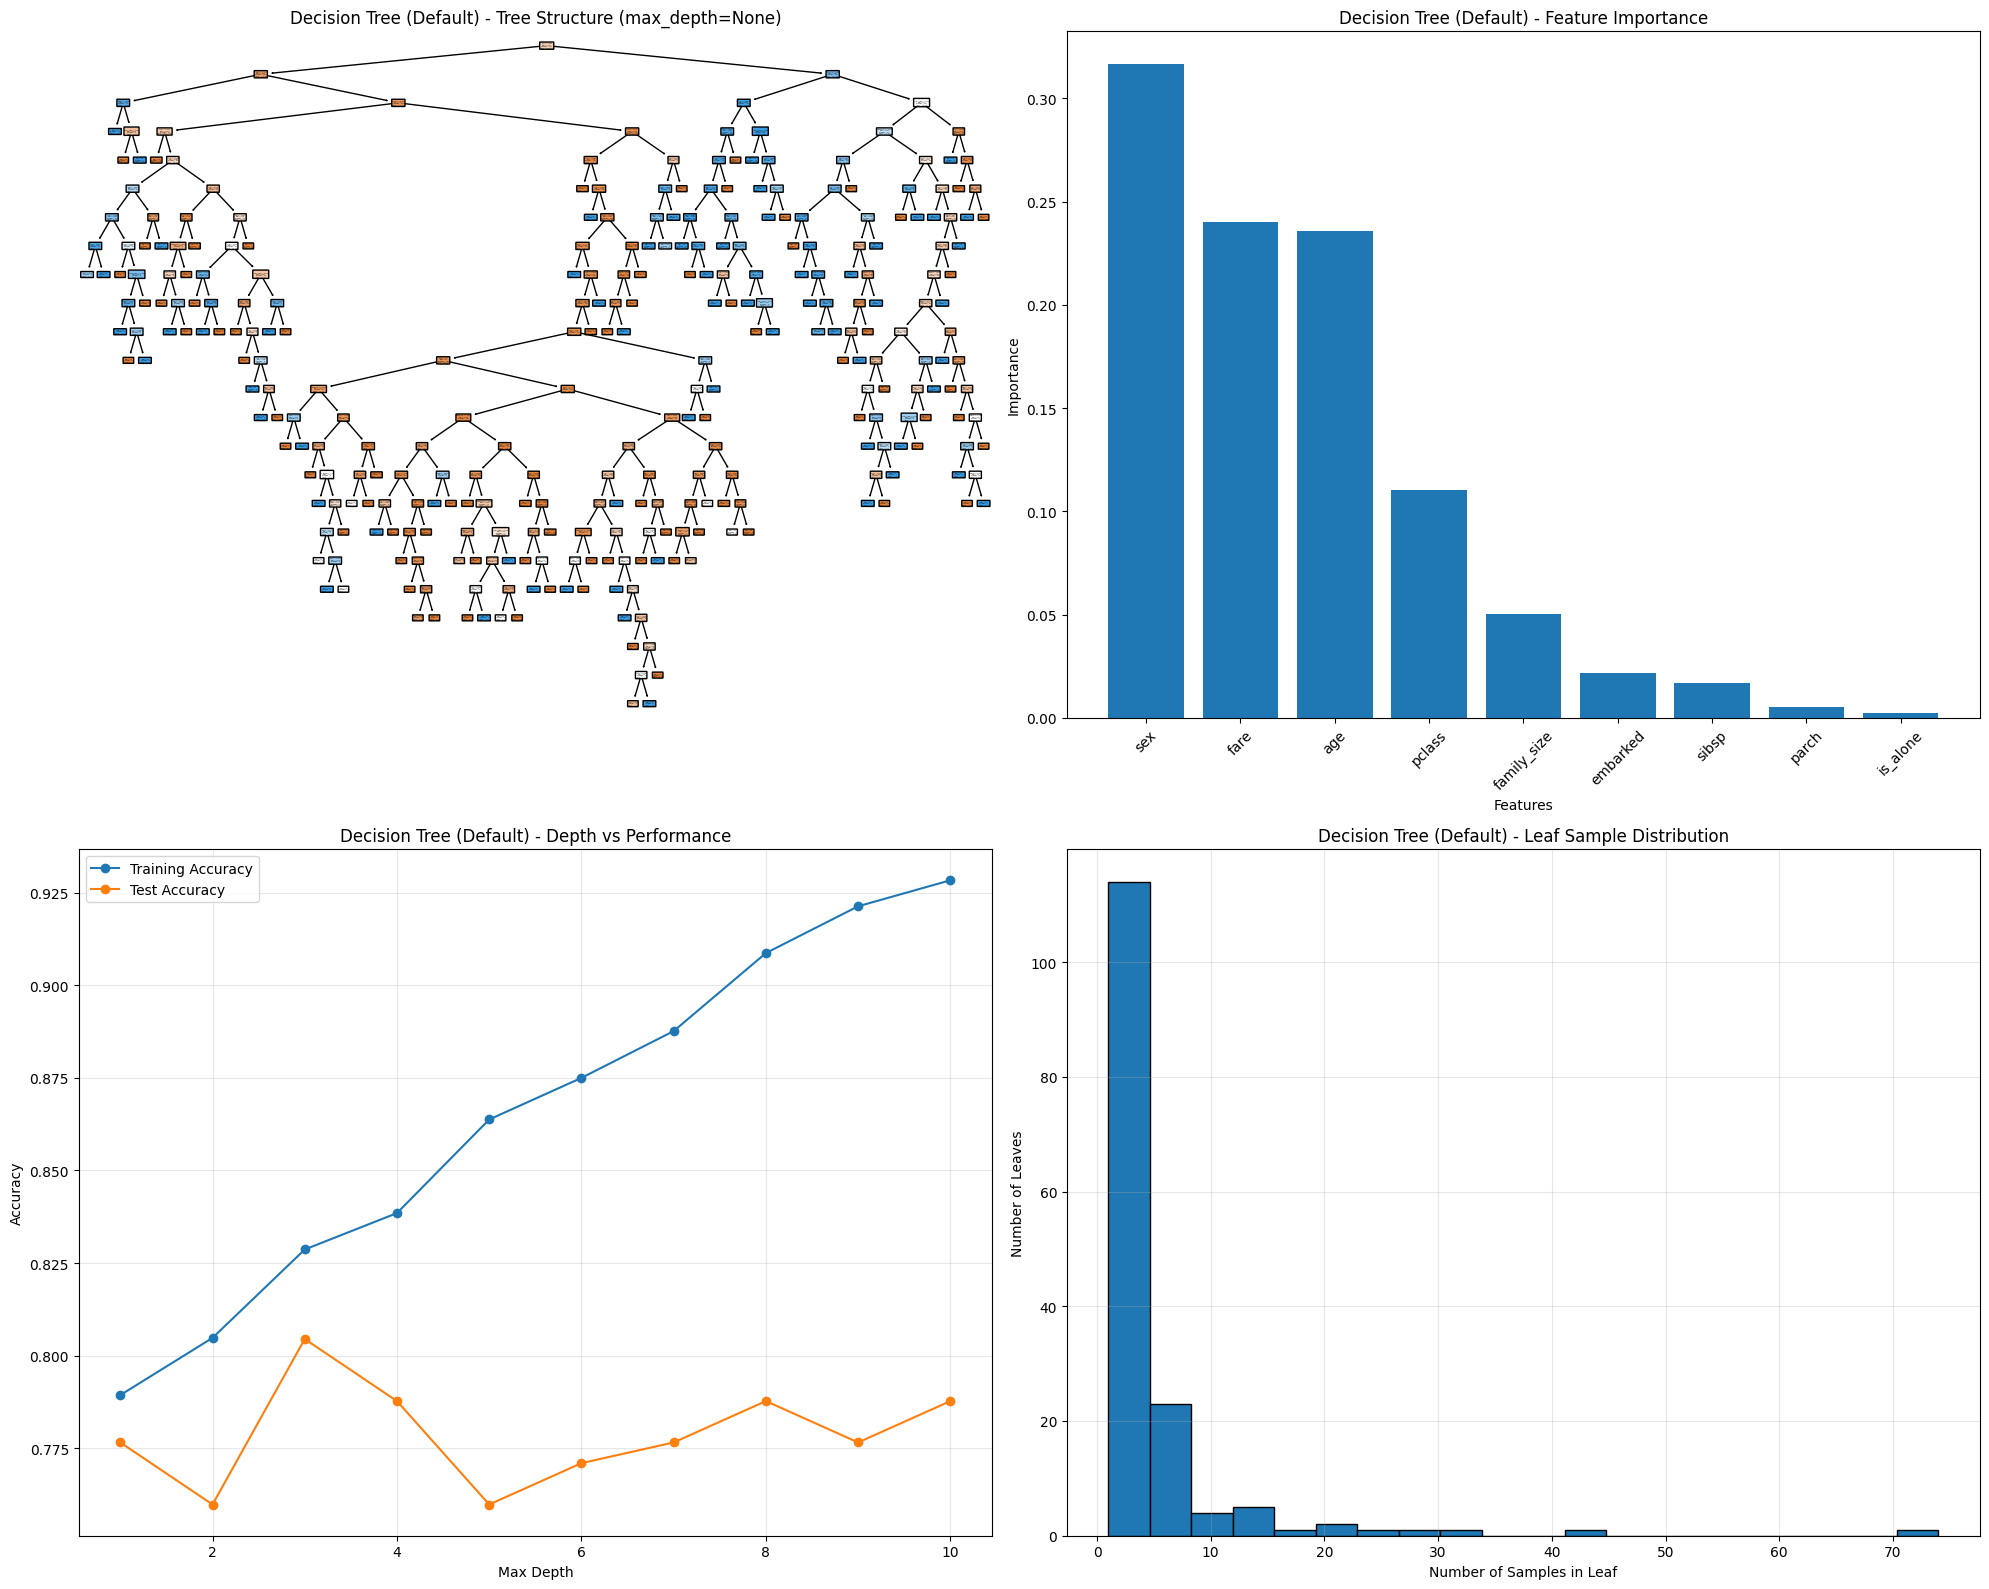

accuracy: 0.8045
cv_mean_accuracy: 0.7852

EVALUATING DECISION TREE (PRUNED)
Decision Tree (Pruned) CV Accuracy: 0.8090


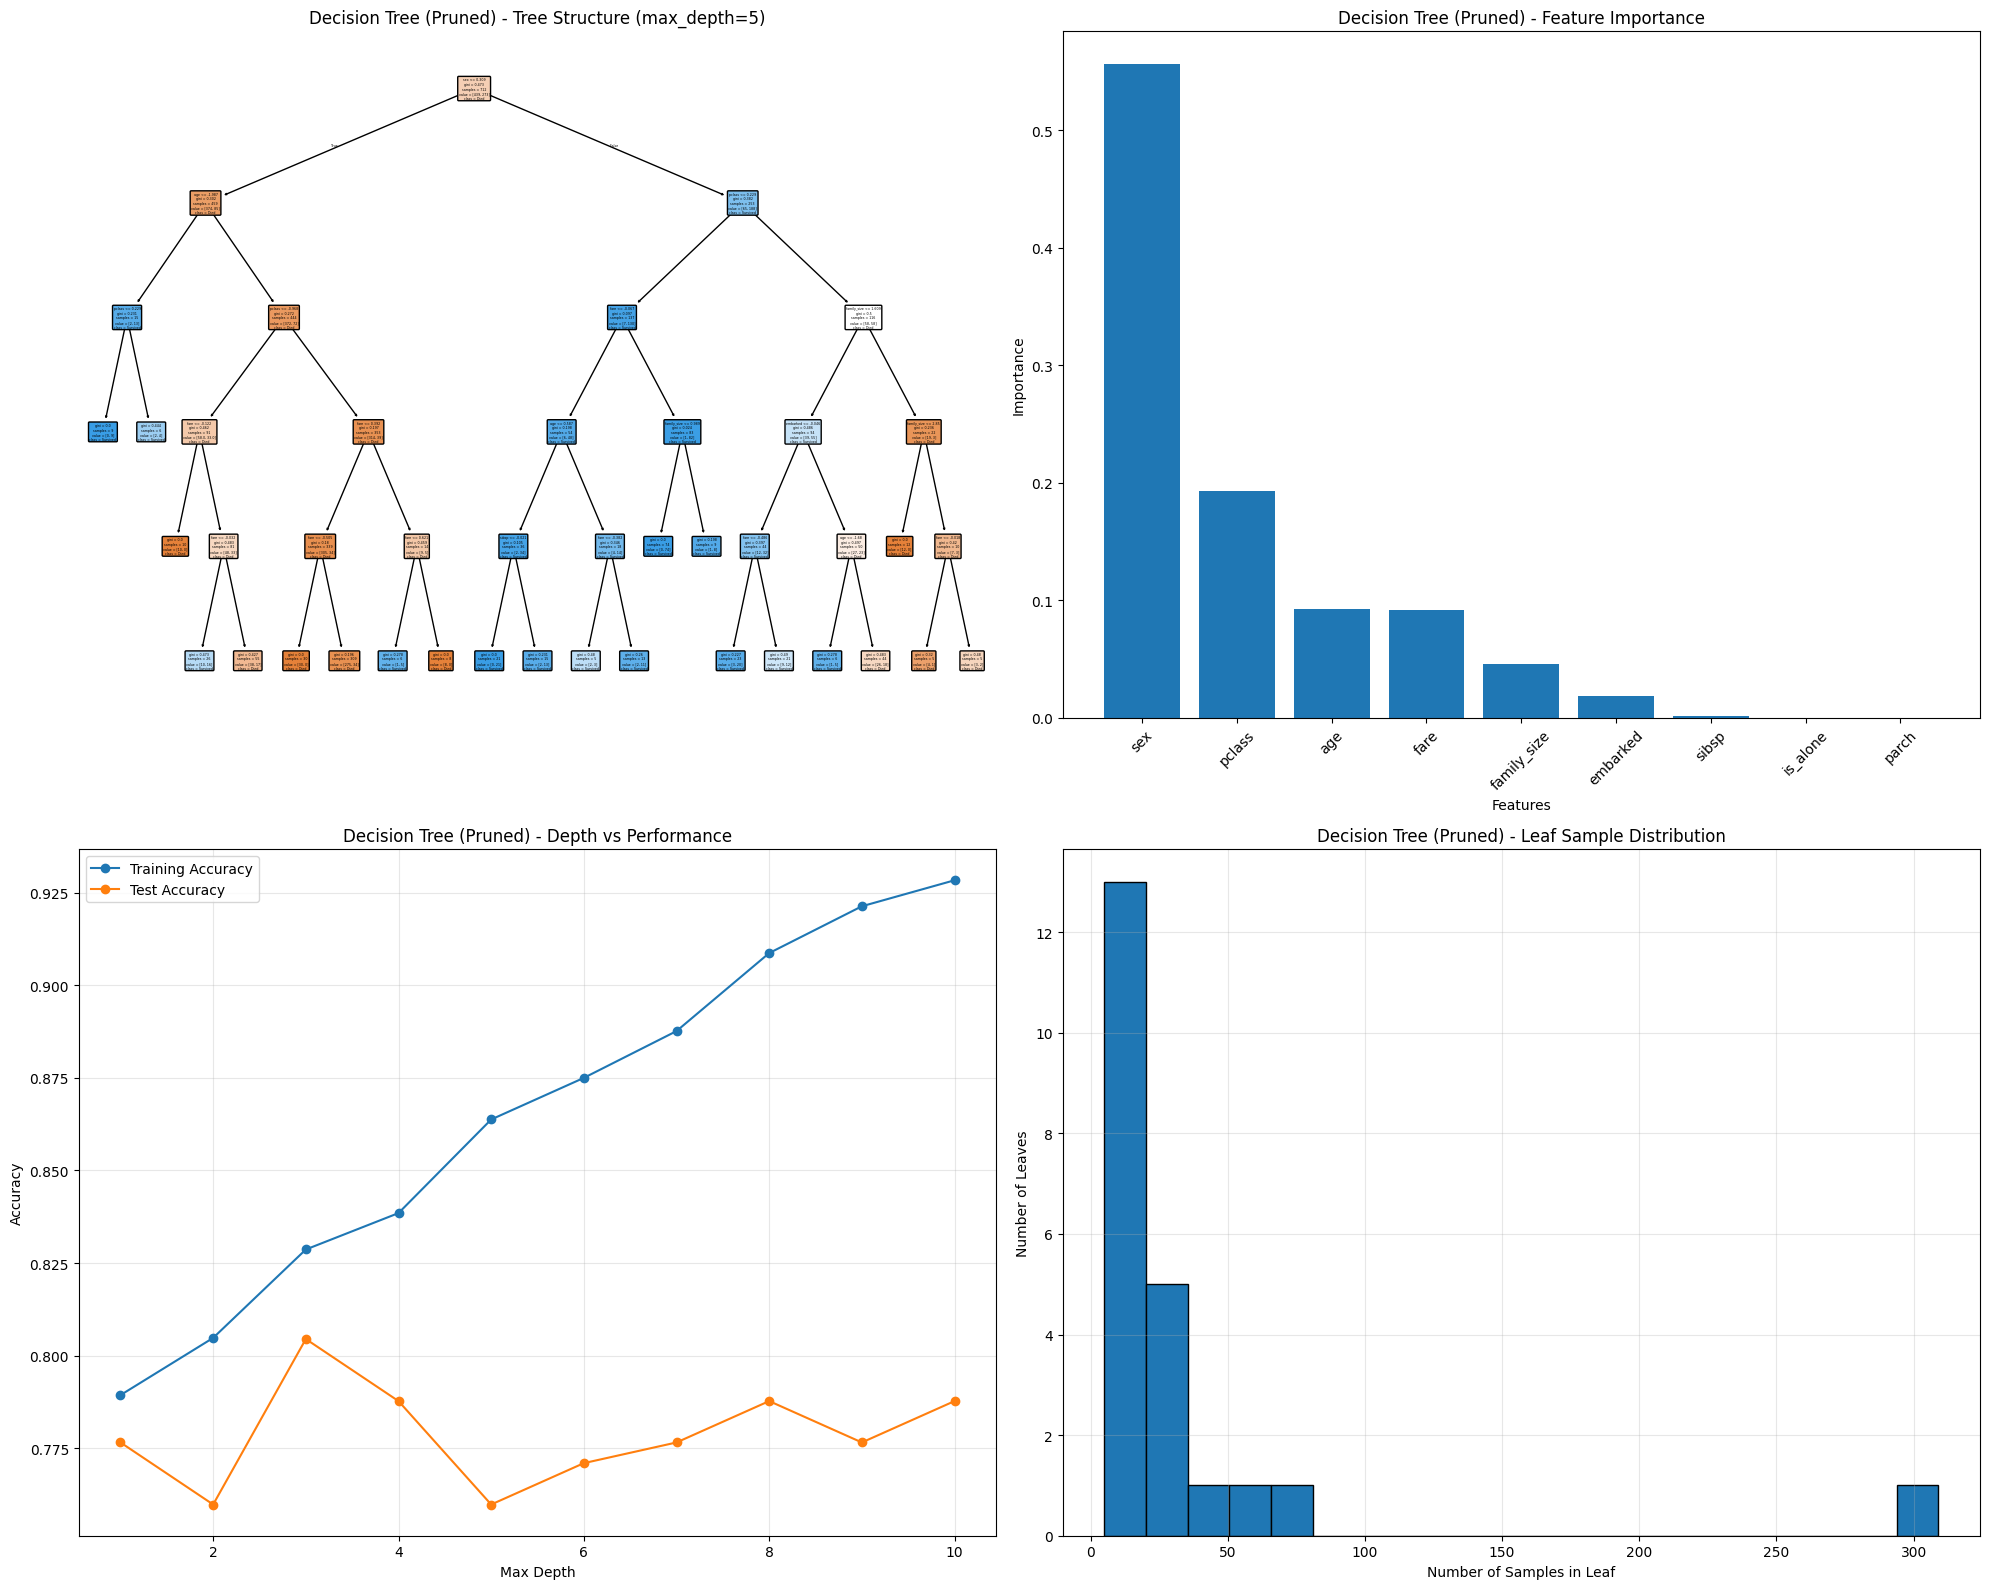

accuracy: 0.7542
cv_mean_accuracy: 0.8090

EVALUATING DECISION TREE (BEST)
Decision Tree (Best) CV Accuracy: 0.8076


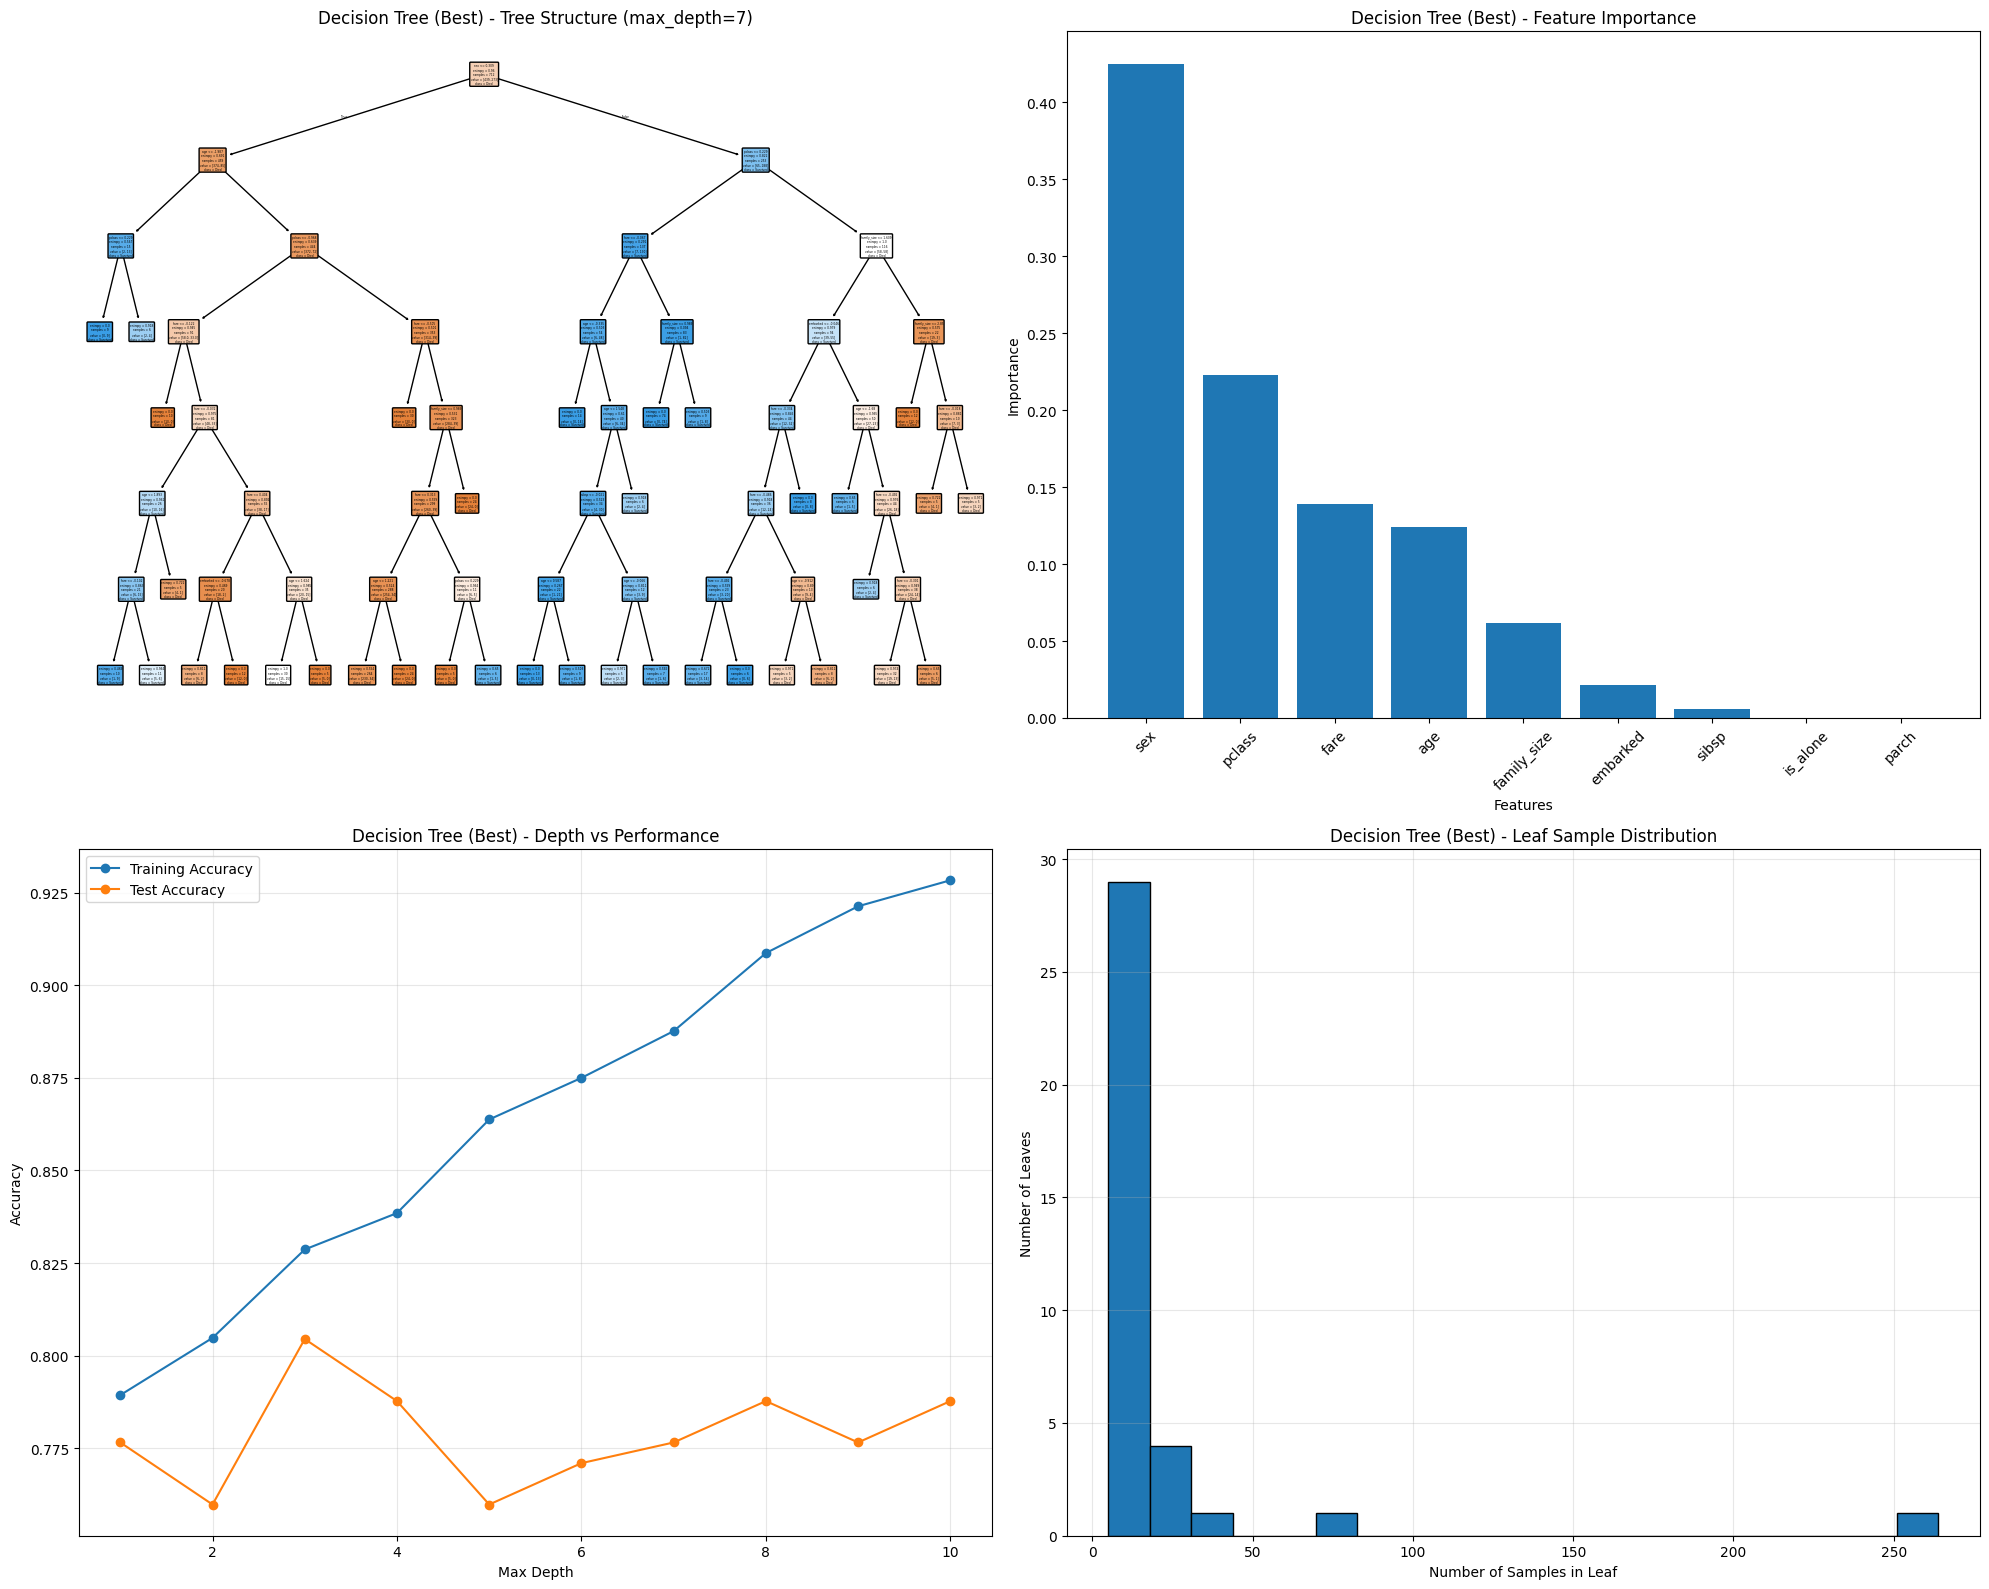

accuracy: 0.7654
cv_mean_accuracy: 0.8076


In [7]:
titanic = sns.load_dataset('titanic')
print(f"Dataset shape: {titanic.shape}")
print(f"Missing values:\n{titanic.isnull().sum()}")

def preprocess_titanic(df):
    df = df.copy()
    

    df['age'] = df['age'].fillna(df['age'].median())
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
    df['fare'] = df['fare'].fillna(df['fare'].median())
    

    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)
    

    df['sex'] = df['sex'].map({'male': 0, 'female': 1})
    df['embarked'] = df['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    

    features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone']
    return df[features], df['survived']


def evaluate_classification_model(model, X_train, X_test, y_train, y_test, cv, model_name="Model"):

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"{model_name} CV Accuracy: {cv_scores.mean():.4f}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    metrics = {"accuracy": accuracy, "cv_mean_accuracy": cv_scores.mean()}
    return metrics, report


X, y = preprocess_titanic(titanic)
feature_names = X.columns.tolist()

print(f"\nPreprocessed data shape: {X.shape}")
print(f"Survival rate: {y.mean():.3f}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


models = {
    'Decision Tree (Default)': DecisionTreeClassifier(random_state=42),
    'Decision Tree (Pruned)': DecisionTreeClassifier(max_depth=5, min_samples_split=10, 
                                                   min_samples_leaf=5, random_state=42),
    'Decision Tree (Best)': DecisionTreeClassifier(random_state=42)  # Will be optimized
}


param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}


grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, 
                          cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)
models['Decision Tree (Best)'] = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


def evaluate_tree_model(model, X_train, X_test, y_train, y_test, cv, model_name, feature_names):    

    metrics, report = evaluate_classification_model(model, X_train, X_test, y_train, y_test, cv, model_name)
    

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    

    plot_tree(model, feature_names=feature_names, class_names=['Died', 'Survived'], 
             filled=True, rounded=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'{model_name} - Tree Structure (max_depth={model.max_depth})')
    

    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    axes[0, 1].bar(range(len(importance)), importance[indices])
    axes[0, 1].set_xlabel('Features')
    axes[0, 1].set_ylabel('Importance')
    axes[0, 1].set_title(f'{model_name} - Feature Importance')
    axes[0, 1].set_xticks(range(len(feature_names)))
    axes[0, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    

    depths = range(1, 11)
    train_scores = []
    test_scores = []
    
    for depth in depths:
        temp_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        temp_model.fit(X_train, y_train)
        train_scores.append(temp_model.score(X_train, y_train))
        test_scores.append(temp_model.score(X_test, y_test))
    
    axes[1, 0].plot(depths, train_scores, 'o-', label='Training Accuracy')
    axes[1, 0].plot(depths, test_scores, 'o-', label='Test Accuracy')
    axes[1, 0].set_xlabel('Max Depth')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title(f'{model_name} - Depth vs Performance')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    

    leaf_samples = model.tree_.n_node_samples[model.tree_.children_left == -1]
    axes[1, 1].hist(leaf_samples, bins=20, edgecolor='black')
    axes[1, 1].set_xlabel('Number of Samples in Leaf')
    axes[1, 1].set_ylabel('Number of Leaves')
    axes[1, 1].set_title(f'{model_name} - Leaf Sample Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return metrics

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"EVALUATING {name.upper()}")
    print('='*60)
    
    metrics = evaluate_tree_model(model, X_train, X_test, y_train, y_test, skf, name, feature_names)
    dt_results[name] = metrics
    
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
